Optimal Total Distance: 17.2892801989182 

Optimal Tour: [('A', 'F'), ('F', 'E'), ('E', 'D'), ('D', 'C'), ('C', 'B'), ('B', 'A')]




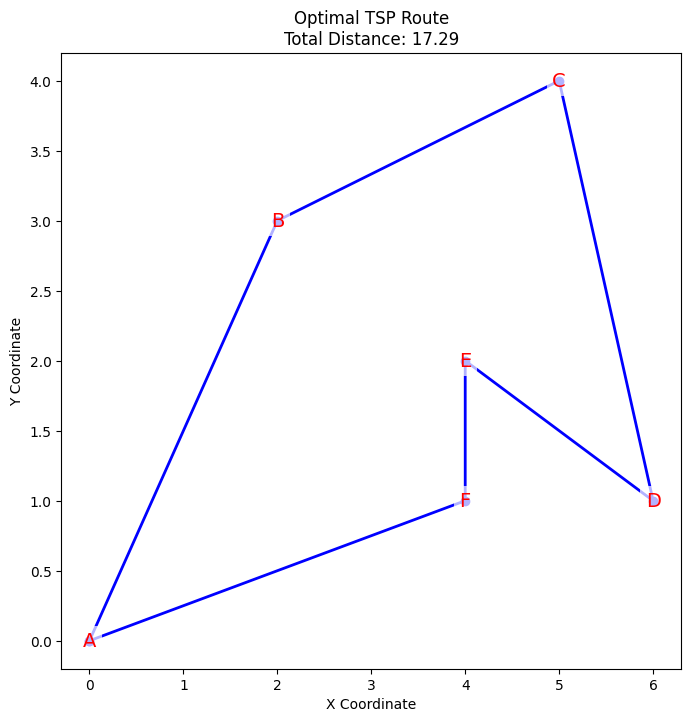

In [9]:
#!pip install pulp
import matplotlib.pyplot as plt
from pulp import *
import numpy as np
import math

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points in 2D space."""
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

def generate_distance_matrix(points):
    """Generate a distance matrix for the given list of points."""
    n = len(points)
    distance_matrix = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean_distance(points[i], points[j])
    return distance_matrix

def solve_tsp_with_pulp(city_points, show_route=True, show_model=False):
    """
    Solve the Traveling Salesman Problem (TSP) using linear programming with PuLP.

    Parameters:
    - city_points (dict): Dictionary of city labels and (x, y) coordinates, e.g., {'A': (0, 0), 'B': (2, 3)}.
    - show_route (bool): If True, displays a plot of the optimal route after solving the TSP. Defaults to True.
    - show_model (bool): If True, prints the linear programming model used to solve the TSP. Defaults to False.
    """

    # Extract points and labels
    labels = list(city_points.keys())
    points = list(city_points.values())

    # Generate distance matrix from points
    distance_matrix = generate_distance_matrix(points)

    # Get number of cities
    n = len(distance_matrix)

    # Initialize the problem
    tsp = LpProblem("Traveling_Salesman_Problem", LpMinimize)

    # Create binary decision variables x_ij for each pair of cities (1 to n)
    x = LpVariable.dicts("x", ((i, j) for i in range(1, n+1) for j in range(1, n+1) if i != j), cat='Binary')

    # Create auxiliary variables u_i for subtour elimination
    u = LpVariable.dicts("u", (i for i in range(1, n+1)), lowBound=0, upBound=n, cat='Continuous')

    # Objective function: Minimize the total travel distance
    tsp += lpSum(distance_matrix[i-1][j-1] * x[i, j] for i in range(1, n+1) for j in range(1, n+1) if i != j), "Total_Distance"

    # Constraints
    # 1. Each city must have exactly one outgoing edge
    for i in range(1, n+1):
        tsp += lpSum(x[i, j] for j in range(1, n+1) if i != j) == 1, f"Outflow_Constraint_{i}"

    # 2. Each city must have exactly one incoming edge
    for j in range(1, n+1):
        tsp += lpSum(x[i, j] for i in range(1, n+1) if i != j) == 1, f"Inflow_Constraint_{j}"

    # 3. Subtour elimination constraints (MTZ constraints)
    for i in range(2, n+1):
        for j in range(2, n+1):
            if i != j:
                tsp += u[i] - u[j] + n * x[i, j] <= n - 1, f"Subtour_Elimination_{i}_{j}"

    # Solve the problem
    tsp.solve()

    # Retrieve and print the solution
    if tsp.status == LpStatusOptimal:
        # Find the tour by starting from city 1 and following the path
        tour = []
        current_city = 1
        visited_cities = set([current_city])

        while len(visited_cities) < n:
            for j in range(1, n+1):
                if current_city != j and value(x[current_city, j]) == 1:
                    tour.append((current_city, j))
                    visited_cities.add(j)
                    current_city = j
                    break

        # Add the last leg returning to the starting city
        for j in range(1, n+1):
            if current_city != j and value(x[current_city, j]) == 1:
                tour.append((current_city, j))
                break

        # Convert tour from numeric indices to city labels
        labeled_tour = [(labels[i - 1], labels[j - 1]) for i, j in tour]

        # Print the results in the specified format
        print("Optimal Total Distance:", value(tsp.objective), "\n")
        print("Optimal Tour:", labeled_tour)

        # Show the model summary if show_model is set to True
        if show_model:
            print("\nModel Summary:\n")
            print(tsp)

        print("\n")

        # Show the Optimal Route if show_route is set to True
        if show_route:
            plot_optimal_route(city_points, labeled_tour, value(tsp.objective))

    else:
        print("No optimal solution found.")
        return None

def plot_optimal_route(city_points, optimal_tour, total_distance):
    """
    Plots the optimal route based on the Euclidean points and labels.

    Parameters:
    - city_points (dict): Dictionary of city labels and (x, y) coordinates.
    - optimal_tour (list of tuples): Optimal path with labels, e.g., [('A', 'C'), ('C', 'D'), ('D', 'B'), ('B', 'A')].
    - total_distance (float): Total distance of the optimal tour.
    """
    ordered_points = [city_points[optimal_tour[0][0]]]
    for _, next_city in optimal_tour:
        ordered_points.append(city_points[next_city])

    # Extract x and y coordinates of the ordered points
    x_coords = [point[0] for point in ordered_points]
    y_coords = [point[1] for point in ordered_points]

    # Plotting the route
    plt.figure(figsize=(8, 8))
    plt.plot(x_coords, y_coords, marker='o', color='blue', linewidth=2)
    plt.title(f"Optimal TSP Route\nTotal Distance: {total_distance:.2f}")

    # Annotate cities with labels
    for label, (x, y) in city_points.items():
        plt.text(x, y, label, color="red", fontsize=14, ha="center", va="center",
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# Example usage
if __name__ == "__main__":
    city_points = {'A': (0, 0), 'B': (2, 3), 'C': (5, 4), 'D': (6, 1), 'E': (4,2), 'F': (4,1)}
    solve_tsp_with_pulp(city_points, show_route=True, show_model=False)